In [313]:
import pandas as pd
from datetime import timedelta
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [314]:
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Admissions Predictors

In [315]:
aux = pd.read_csv('data.csv',  index_col=0, parse_dates=[0])
df = pd.DataFrame(aux['occupancy'])

In [316]:
df.head()

,occupancy
2014-04-03,8.0
2014-04-04,10.0
2014-04-05,21.0
2014-04-06,26.0
2014-04-07,28.0


## The Real Deal

In [317]:
def decomp(df, p):
    df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
    df['r_occupancy'] = df['occupancy']-df['s_occupancy']
    aux_df = df.dropna()
    return df, aux_df

In [335]:
def xy_matrices(df, key,q, l):  
    predictors_dict = {}
    for i in range(len(df)-(q+l-1)):
        predictors_dict[i] = df[key].iloc[i:i+q+l].values #the 1 is actually l
        
    predictors = pd.DataFrame(predictors_dict).T 
    predictors = transform(predictors) 
    
    y = predictors[np.arange(q, q+l, 1)].values #here I need l dependence 
    x_predictors = predictors.drop(np.arange(q, q+l, 1), axis=1).values #here too
    
    return x_predictors, y

In [336]:
def transform(df): #acts on dataframes, scaler is global function/variable
    X = df.values
    X = scaler.fit_transform(X)
    return pd.DataFrame(X)

In [337]:
def inverse_transform(X, y): #acts on arrays, scaler is global function/variable
    aux = np.column_stack((X,y)) 
    aux = scaler.inverse_transform(aux)
    return aux[:,-1]

In [338]:
def chrono_split(X,y, f):
    l = len(y)
    X_train = X[0:int(f*l)]
    X_test = X[int(f*l):]
    y_train = y[0:int(f*l)]
    y_test = y[int(f*l):]
    return X_train, X_test, y_train, y_test

In [339]:
def max_error(y_test, y_forecast):
    return  np.max(np.abs(y_test-y_forecast))
def abs_error(y_test, y_forecast):
    return np.mean(np.abs(y_test-y_forecast))
def rsm_error(y_test, y_forecast):
    return np.sqrt(np.sum((y_test-y_forecast)**2))/np.sqrt(len(y_test))

In [340]:
model_linear = linear_model.LinearRegression()
model_nene = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-9,
                    hidden_layer_sizes=(350, 350), random_state=0,
                    max_iter=2000,  warm_start=True)
model_tree = tree.DecisionTreeRegressor()
model_gbr = GradientBoostingRegressor(n_estimators=750, learning_rate=0.1,
                                      max_depth=1, random_state=0, loss='ls',
                                      warm_start=True)
model_svr = svm.SVR(gamma='auto')

scaler = StandardScaler()

In [341]:
p = 31 #smoothing
q = 7 #lagging

In [342]:
df, aux_df = decomp(df, p)

In [343]:
models = {'linear':model_linear ,'nene': model_nene, 'tree': model_tree, 
          'gbr': model_gbr, 'svr': model_svr}
errors = {'max':max_error ,'abs': abs_error, 'rsm':rsm_error}

## Smooth

In [352]:
l = 2
f = 0.9
X, y = xy_matrices(aux_df,'s_occupancy' ,q, l)
#print(X.shape, y.shape)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [353]:
#sigma = np.std(y_train_r)
#true_data = aux_df['occupancy'].tail(X_test.shape[0]).values

In [354]:
#for model in models:
models['linear'].fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [357]:
models['linear'].predict(X_test)

array([[1.17861563, 1.19621096],
       [1.27089584, 1.31070462],
       [1.31215121, 1.34156139],
       [1.2874653 , 1.28744297],
       [1.19021588, 1.15391951],
       [1.29317092, 1.31761404],
       [1.20415922, 1.18804509],
       [1.22279747, 1.22258834],
       [1.26861002, 1.27657274],
       [1.33220729, 1.35410933],
       [1.37609782, 1.39147408],
       [1.46960815, 1.49687108],
       [1.54153986, 1.56964648],
       [1.58428   , 1.60563339],
       [1.68474209, 1.72320218],
       [1.76600021, 1.80732738],
       [1.80552085, 1.83434843],
       [1.77662954, 1.77504755],
       [1.71528849, 1.69428698],
       [1.70768115, 1.70261915],
       [1.65360919, 1.63890641],
       [1.67459724, 1.67698441],
       [1.64784814, 1.63441426],
       [1.65896205, 1.65073004],
       [1.72292567, 1.73260283],
       [1.73741893, 1.7379906 ],
       [1.66656122, 1.63386328],
       [1.65750446, 1.63539446],
       [1.61331089, 1.58974581],
       [1.65670621, 1.66441705],
       [1.

## Random Walk

In [274]:
l = 1
f = 0.9
X, y = xy_matrices(aux_df,'s_occupancy' ,q, l)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [275]:
X_r, y_r = xy_matrices(aux_df,'r_occupancy' ,q, l)
X_train_r, X_test_r, y_train_r, y_test_r = chrono_split(X, y, f)

sigma = np.std(y_train_r)
true_data = aux_df['occupancy'].tail(X_test.shape[0]).values

In [276]:
for model in models:
    models[model].fit(X_train, y_train)

/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:1321: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [277]:
prob_dist = {}

for trial in range(100):
    step = X_test[-1,:]
    random_walk = np.array([])
    for day in range(0,X_test.shape[0]):
        dy = np.random.normal(loc=0, scale = sigma)
        y_rw = models['linear'].predict(step.reshape(1,-1))[0]
        step = np.append(step[1:], y_rw) + 0.1*dy
        random_walk = np.append(random_walk, y_rw)
    random_walk = inverse_transform(X_test, random_walk)
    prob_dist[trial] = random_walk

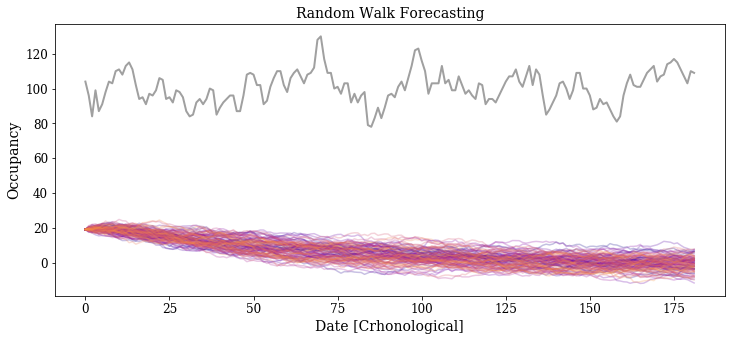

In [278]:
cmap = cm.plasma
colors = np.linspace(0,0.75, 100)

plt.figure(figsize=(12,5))
for trial in range(100):
    plt.plot(prob_dist[trial], alpha = 0.25, color=cmap(colors[trial]))
    
plt.plot(true_data, color='gray', alpha=0.75, label='target', lw=2)

plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(loc='best', fontsize=12)
plt.title('Random Walk Forecasting', fontsize = 14)
#plt.ylim([-10,150])
plt.show()

In [ ]:
## Regular Smooth

In [68]:
y_forecast = {} #I can make this chunk a function
error_per_model = {}

y_test_transformed = inverse_transform(X_test, y_test)
for model in models:
    y_forecast[model] = models[model].predict(X_test)
    y_forecast[model] = inverse_transform(X_test, y_forecast[model])
    
    aux_e = np.array([])
    for error in errors:
        aux_error = errors[error](y_test_transformed, y_forecast[model])
        aux_e = np.append(aux_e, aux_error)
    error_per_model[model] = aux_e

error_df = pd.DataFrame(error_per_model)
error_df = error_df.set_index([list(errors.keys())])

In [69]:
cmap = cm.plasma
colors = np.linspace(0,0.75, len(y_forecast))

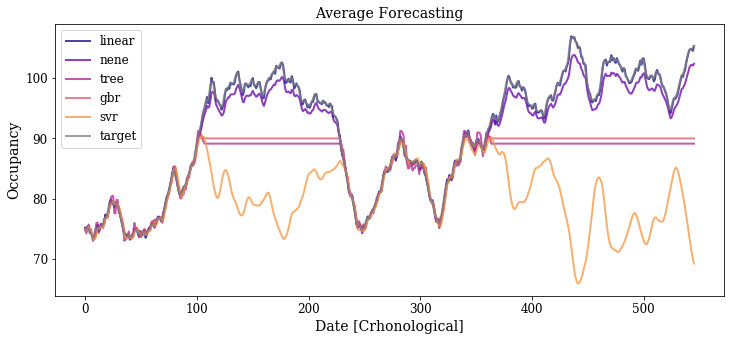

In [70]:
plt.figure(figsize=(12,5))

for model,c in zip(models, colors):    
    plt.plot(y_forecast[model], color=cmap(c), alpha=0.75, lw=2, label='%s'%model)

plt.plot(y_test_transformed, color='gray', alpha=0.75, label='target', lw=2)

plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Average Forecasting', fontsize = 14)
plt.savefig('forecasting.pdf', bbox='tight')
plt.show()

In [72]:
error_df

,linear,nene,tree,gbr,svr
max,1.174248,4.088091,17.782368,16.920240,39.508906
abs,0.307424,1.179046,5.714828,5.179663,11.124713
rsm,0.374530,1.477636,7.647524,7.030965,15.694377


## Residual

In [24]:
l = 1
f = 0.7
X, y = xy_matrices(aux_df,'r_occupancy' ,q, l)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [25]:
for model in models:
    models[model].fit(X_train, y_train)

In [26]:
y_forecast = {}
error_per_model = {}

y_test_transformed = inverse_transform(X_test, y_test)
for model in models:
    y_forecast[model] = models[model].predict(X_test)
    y_forecast[model] = inverse_transform(X_test, y_forecast[model])

    aux_e = np.array([])
    for error in errors:
        aux_error = errors[error](y_test_transformed, y_forecast[model])
        aux_e = np.append(aux_e, aux_error)
    error_per_model[model] = aux_e

In [27]:
error_df = pd.DataFrame(error_per_model)
error_df = error_df.set_index([list(errors.keys())])

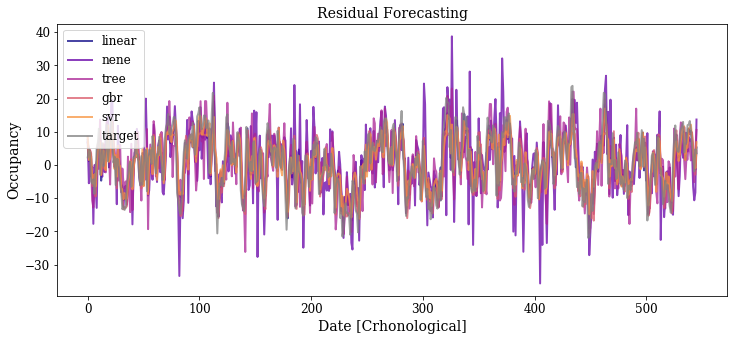

In [28]:
plt.figure(figsize=(12,5))

for model,c in zip(models, colors): 
    plt.plot(y_forecast[model], color=cmap(c), alpha=0.75, lw=2, label='%s'%model)


y_test_transformed = inverse_transform(X_test, y_test)
plt.plot(y_test_transformed, color='gray', alpha=0.75, label='target', lw=2)

plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Residual Forecasting', fontsize = 14)
plt.savefig('residual_forecasting.pdf', bbox='tight')
plt.show()

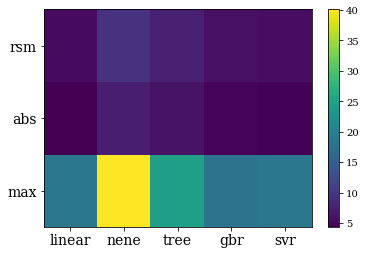

In [29]:
plt.pcolor(error_df)
plt.colorbar()

plt.yticks(np.arange(0.5, len(error_df.index), 1), error_df.index, fontsize=14)
plt.xticks(np.arange(0.5, len(error_df.columns), 1), error_df.columns, fontsize=14)
plt.show()

In [30]:
error_df

,linear,nene,tree,gbr,svr
max,18.494468,40.106896,24.371818,17.944106,18.493761
abs,4.409694,7.351389,6.131017,4.748975,4.558316
rsm,5.436495,9.519451,7.715357,5.842998,5.619547
